In [5]:
import pandas as pd
import requests as req
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:

timestamp = int(datetime.timestamp(datetime.now()))
#download_url = "https://query1.finance.yahoo.com/v7/finance/download/%5EIXIC?period1=34560000&period2={}&interval=1mo&events=history".format(timestamp)
download_url = "https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-1325635200&period2={}&interval=1mo&events=history".format(timestamp)
r = req.get(download_url, allow_redirects=True)
open('historical_data.csv', 'wb').write(r.content)

81290

In [58]:
historical_data = pd.read_csv("historical_data.csv")
historical_data = historical_data[pd.to_datetime(historical_data['Date']).dt.month == 1]
historical_data.set_index('Date', inplace=True)

adj_close_year = historical_data['Adj Close']
rt = 100 * np.log(adj_close_year / adj_close_year.shift(1))


In [59]:
average_rt = rt.mean()
print(average_rt)

rm = np.abs(rt - rt.shift(1))

average_rm = rm.mean()
print(average_rm)

sigma = 2.66 * average_rm / 3 
print(sigma)

regions = np.arange(3,-4,-1) * sigma + average_rt
print(regions)



5.665931044069212
19.82392390290696
17.57721252724417
[ 58.39756863  40.8203561   23.24314357   5.66593104 -11.91128148
 -29.48849401 -47.06570654]


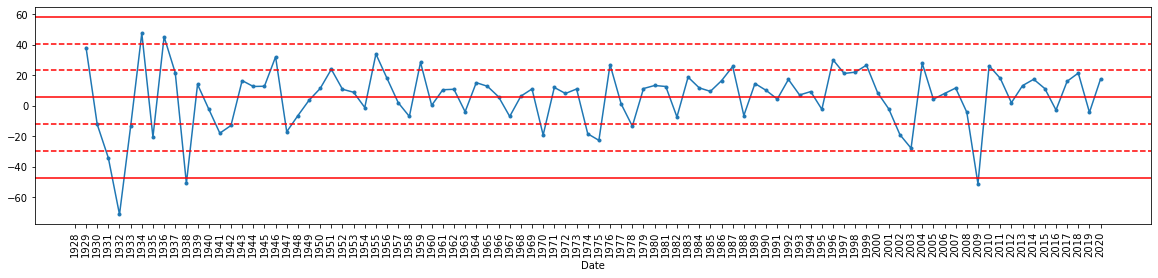

In [60]:


xticks = np.array(pd.to_datetime(rt.index).year.to_list())


my_plot = rt.plot(style='.-')
plt.xticks(np.arange(rt.shape[0])[::1], xticks[::1], rotation=90)

plt.rcParams['figure.figsize'] = [20, 4]
plt.axhline(y=regions[0], color='r', linestyle='-')
plt.axhline(y=regions[1], color='r', linestyle='--')
plt.axhline(y=regions[2], color='r', linestyle='--')
plt.axhline(y=regions[3], color='r', linestyle='-')
plt.axhline(y=regions[4], color='r', linestyle='--')
plt.axhline(y=regions[5], color='r', linestyle='--')
plt.axhline(y=regions[6], color='r', linestyle='-')



In [61]:
def find_condition(data, window, condition, min_number=None):
    _min_number = window if min_number is None else min_number
    finds = []
    for i in range(len(data) - window + 1):
        count = sum(map(condition, data[i:i+window]))        
        if count >= _min_number:
            finds.append(i)
    return finds

# 1) Outside limits

signal_1 = find_condition(rt, 1, lambda x: x > regions[0]  or regions[6] > x)
print("Signal 1: ", signal_1)

# 2) 2 out of 3 points in region A

signal_2 = find_condition(rt, 3, lambda x:  regions[0] > x > regions[1]  or regions[5] > x > regions[6] , 2)
print("Signal 2: ", signal_2)

# 3) 4 out of 5 points in region A and/or B

signal_3 = find_condition(rt, 5, lambda x: regions[0] > x > regions[2]  or regions[4] > x > regions[6], 4)
print("Signal 3: ", signal_3)

# 4) 9 consecutive points on one side of central axis
signal_4 = find_condition(rt, 9, lambda x: x > regions[3] ) + find_condition(rt, 9, lambda x: x < regions[3])
print("Signal 4: ", signal_4)

# 5) 6 consecutive points increasing/decreasing only
# 6) 14 consecutive points in oscilation

# 7) 15 consecutive points in region C
signal_7 = find_condition(rt, 15, lambda x: regions[2] > x > regions[4] )
print("Signal 7: ", signal_7)

# 7a) 8 consecutive points in region C
signal_7a = find_condition(rt, 8, lambda x: regions[2] > x > regions[4] )
print("Signal 7a: ", signal_7a)

Signal 1:  [4, 10, 81]
Signal 2:  [6]
Signal 3:  [1, 2, 3, 4, 5, 46]
Signal 4:  []
Signal 7:  []
Signal 7a:  [32, 33, 34, 51, 60, 83, 84, 85]
